# Tutorial - Run DE on Gli3-KO dataset

This tutorial demonstrates how to perform comprehensive differential expression analysis on the Gli3-KO dataset using the delnx package. We will cover pseudobulking, differential expression analysis, visualization, and gene set enrichment analysis (GSEA).

## Table of Contents

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Pseudobulking](#2-pseudobulking)
3. [Differential Expression Analysis](#3-differential-expression-analysis)
4. [Visualization](#4-visualization)
   - [Volcano Plots](#volcano-plots)
   - [Multi-condition Heatmaps](#multi-condition-heatmaps)
   - [Dot Plots](#dot-plots)
5. [Gene Set Enrichment Analysis (GSEA)](#5-gene-set-enrichment-analysis-gsea)

## 1. Setup and Data Loading

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import delnx as dx
from pathlib import Path

# Global Scanpy settings
sc.settings.verbosity = 2  # Show progress
sc.settings.set_figure_params(
    dpi=150,  # High-res output
    dpi_save=300,  # High-res when saving
    format="png",  # or 'pdf', 'svg'
    facecolor="white",  # or 'none' for transparent
    frameon=False,  # No outer frame
    vector_friendly=True,  # No rasterization warnings
    fontsize=10,  # Base font size
    figsize=(4, 4),  # Default figure size
    transparent=True,  # Transparent background if saving
)

mpl.rcParams.update(
    {
        "svg.fonttype": "none",  # Keep SVG text selectable
        "pdf.fonttype": 42,  # Embed fonts in PDFs (TrueType)
        "legend.fontsize": 6,
        "axes.titlesize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)

# Optional: remove scanpy's auto-show
sc.settings.autoshow = False

# Setup keys
sample_key = "batch"
group_key = "cell_type"
condition_key = "condition"

#### Load & Visualize data

In [3]:
# Load the dataset
data_dir = "/projects/site/pred/ihb-g-deco/PUBLIC_DATA/scg/brain_organoids/FleckTreutlein2022"
adata_path = Path(data_dir) / "GLI3_KO_45d.h5ad"
adata = sc.read(adata_path)

# Remove unwanted cell types
adata = adata[~adata.obs["cell_type"].isin(["ctx_ip", "ctx_ex", "ctx_npc"])]

# Make sure the metadata is formatted as categoricals
adata.obs[sample_key] = adata.obs["organoid"].astype(str)
adata.obs[sample_key] = pd.Categorical(adata.obs[sample_key], ordered=True)
adata.obs[group_key] = adata.obs["cell_type"].astype(str)
adata.obs[group_key] = pd.Categorical(adata.obs[group_key], ordered=True)
adata.obs[condition_key] = adata.obs["GLI3_KO"].astype(str)
adata.obs[condition_key] = pd.Categorical(adata.obs[condition_key], ordered=True)
# Store raw counts in a separate layer
adata.layers["counts"] = adata.X.copy()
# Store whole object under raw (this is needed for dotplots)
adata.raw = adata.copy()

/tmp/ipykernel_2826167/175458125.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[sample_key] = adata.obs["organoid"].astype(str)


In [4]:
# Some basic preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [5]:
adata

AnnData object with n_obs × n_vars = 19844 × 18653
    obs: 'organoid', 'GLI3_KO', 'cell_type', 'batch', 'condition'
    uns: 'log1p'
    obsm: 'pca', 'umap'
    layers: 'counts'

[<Axes: title={'center': 'condition'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>]

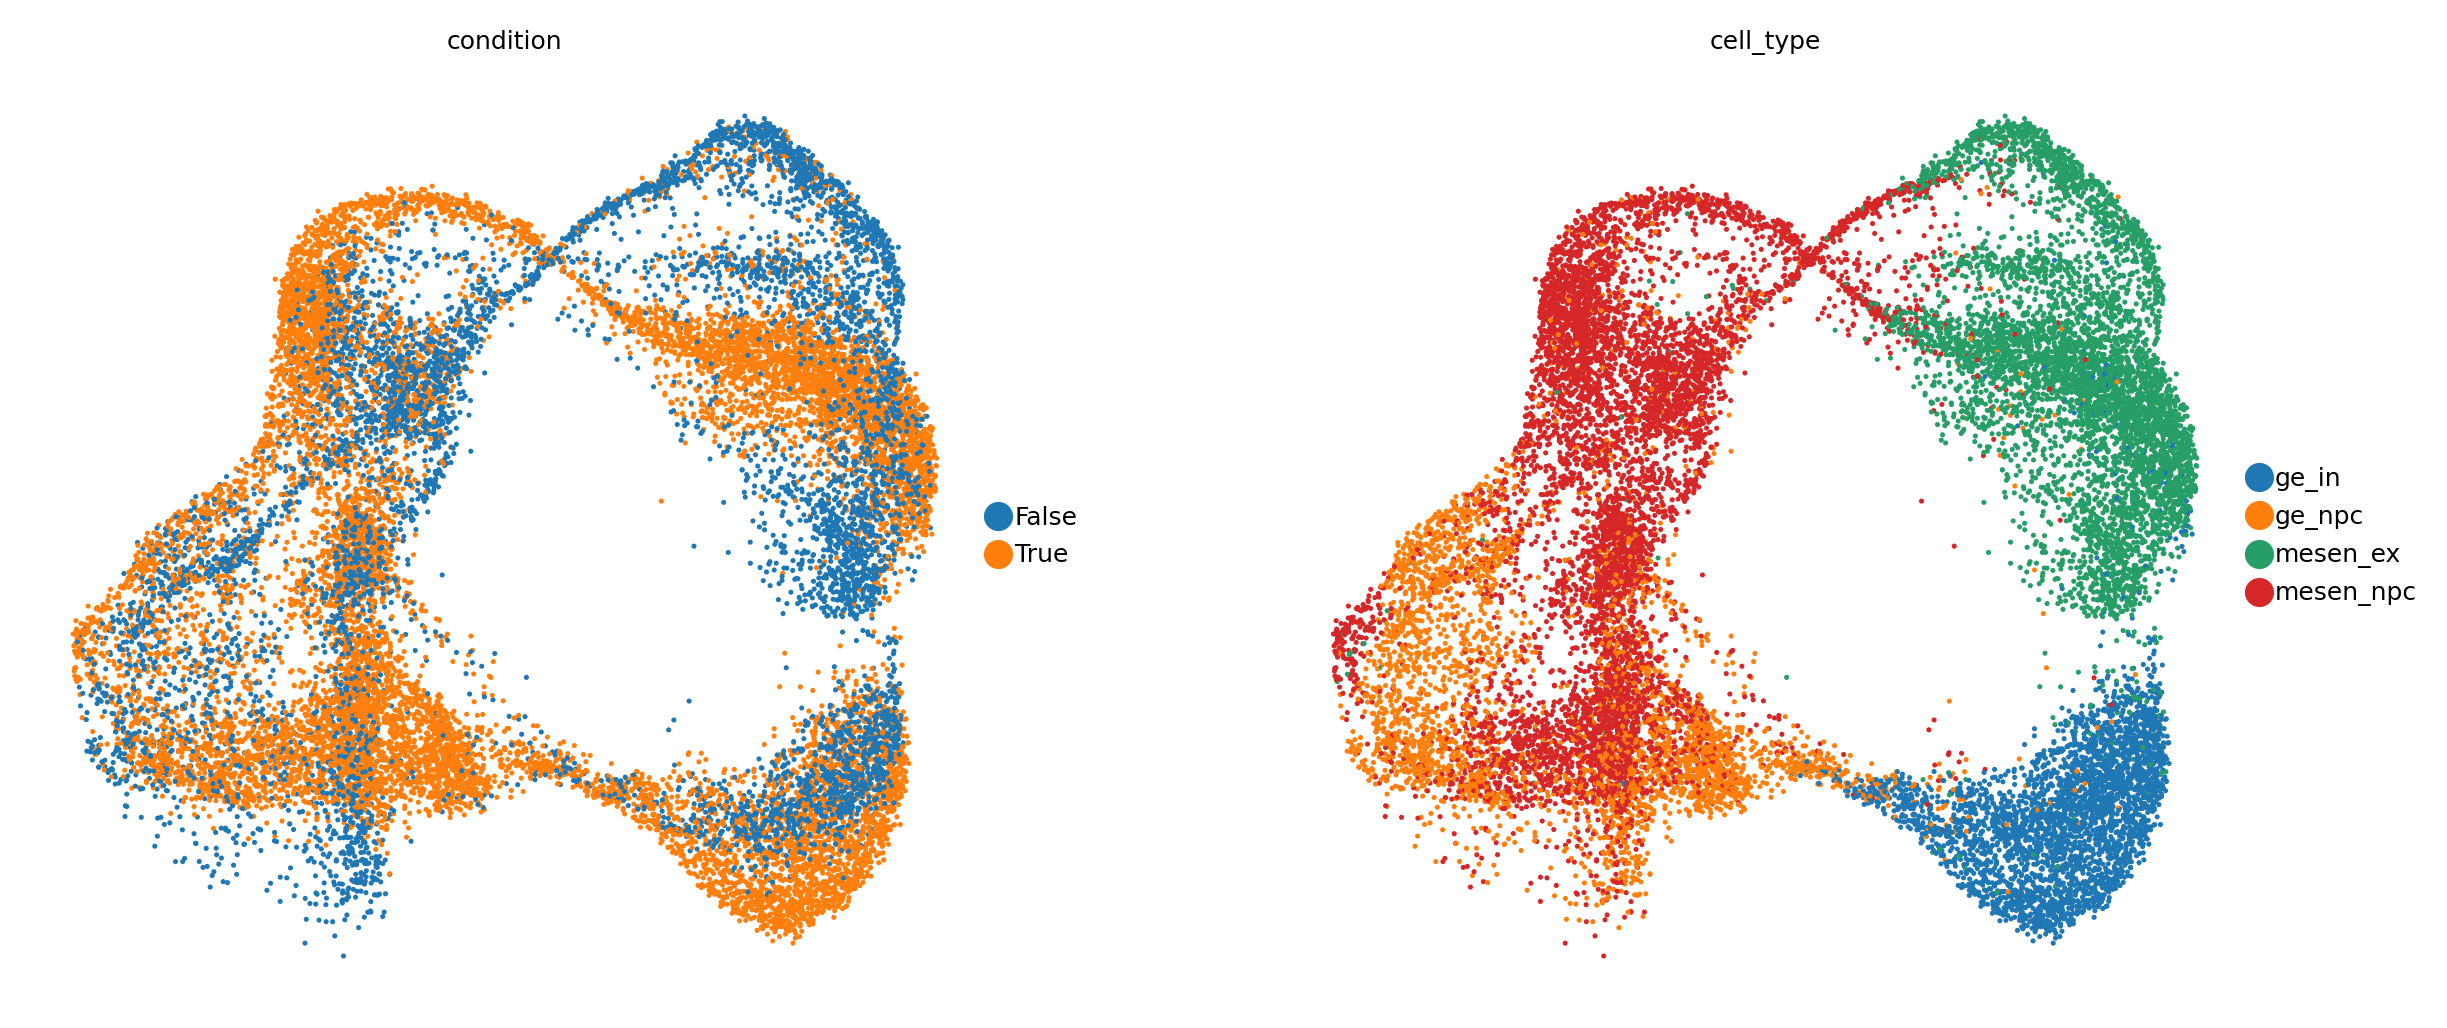

In [6]:
sc.pl.umap(adata, color=[condition_key, group_key])

#### Filter out lowly detected genes

Before downstream analysis, we remove genes with very low overall expression across all cells, as these are often uninformative and may introduce noise.

To do this, we:

1. **Sum total counts per gene**  
   For each gene, we calculate the total number of counts across all cells.

2. **Rank genes by total count**  
   This helps visualize the distribution of gene expression and identify an appropriate cutoff for filtering.

3. **Visualize counts vs rank**  
   A rank-ordered plot (gene rank vs total count) reveals the long tail of lowly expressed genes.

4. **Apply a filtering threshold**  
   We select genes to keep using one of two methods:
   - **Absolute threshold**: Keep genes with total counts above a fixed cutoff.
   - **Quantile threshold** *(used here)*: Keep the top proportion of expressed genes. For example:

     ```python
     keep_mask = dx.pp.filter_genes(adata, mode="quantile", quantile=0.25)
     ```

     This keeps the top 25% of genes based on total expression, filtering out the bottom 75% with lowest overall expression.

This step reduces dimensionality and improves signal-to-noise ratio in downstream analysis.


In [7]:
keep_mask = dx.pp.filter_genes(adata, mode="quantile", quantile=0.25)

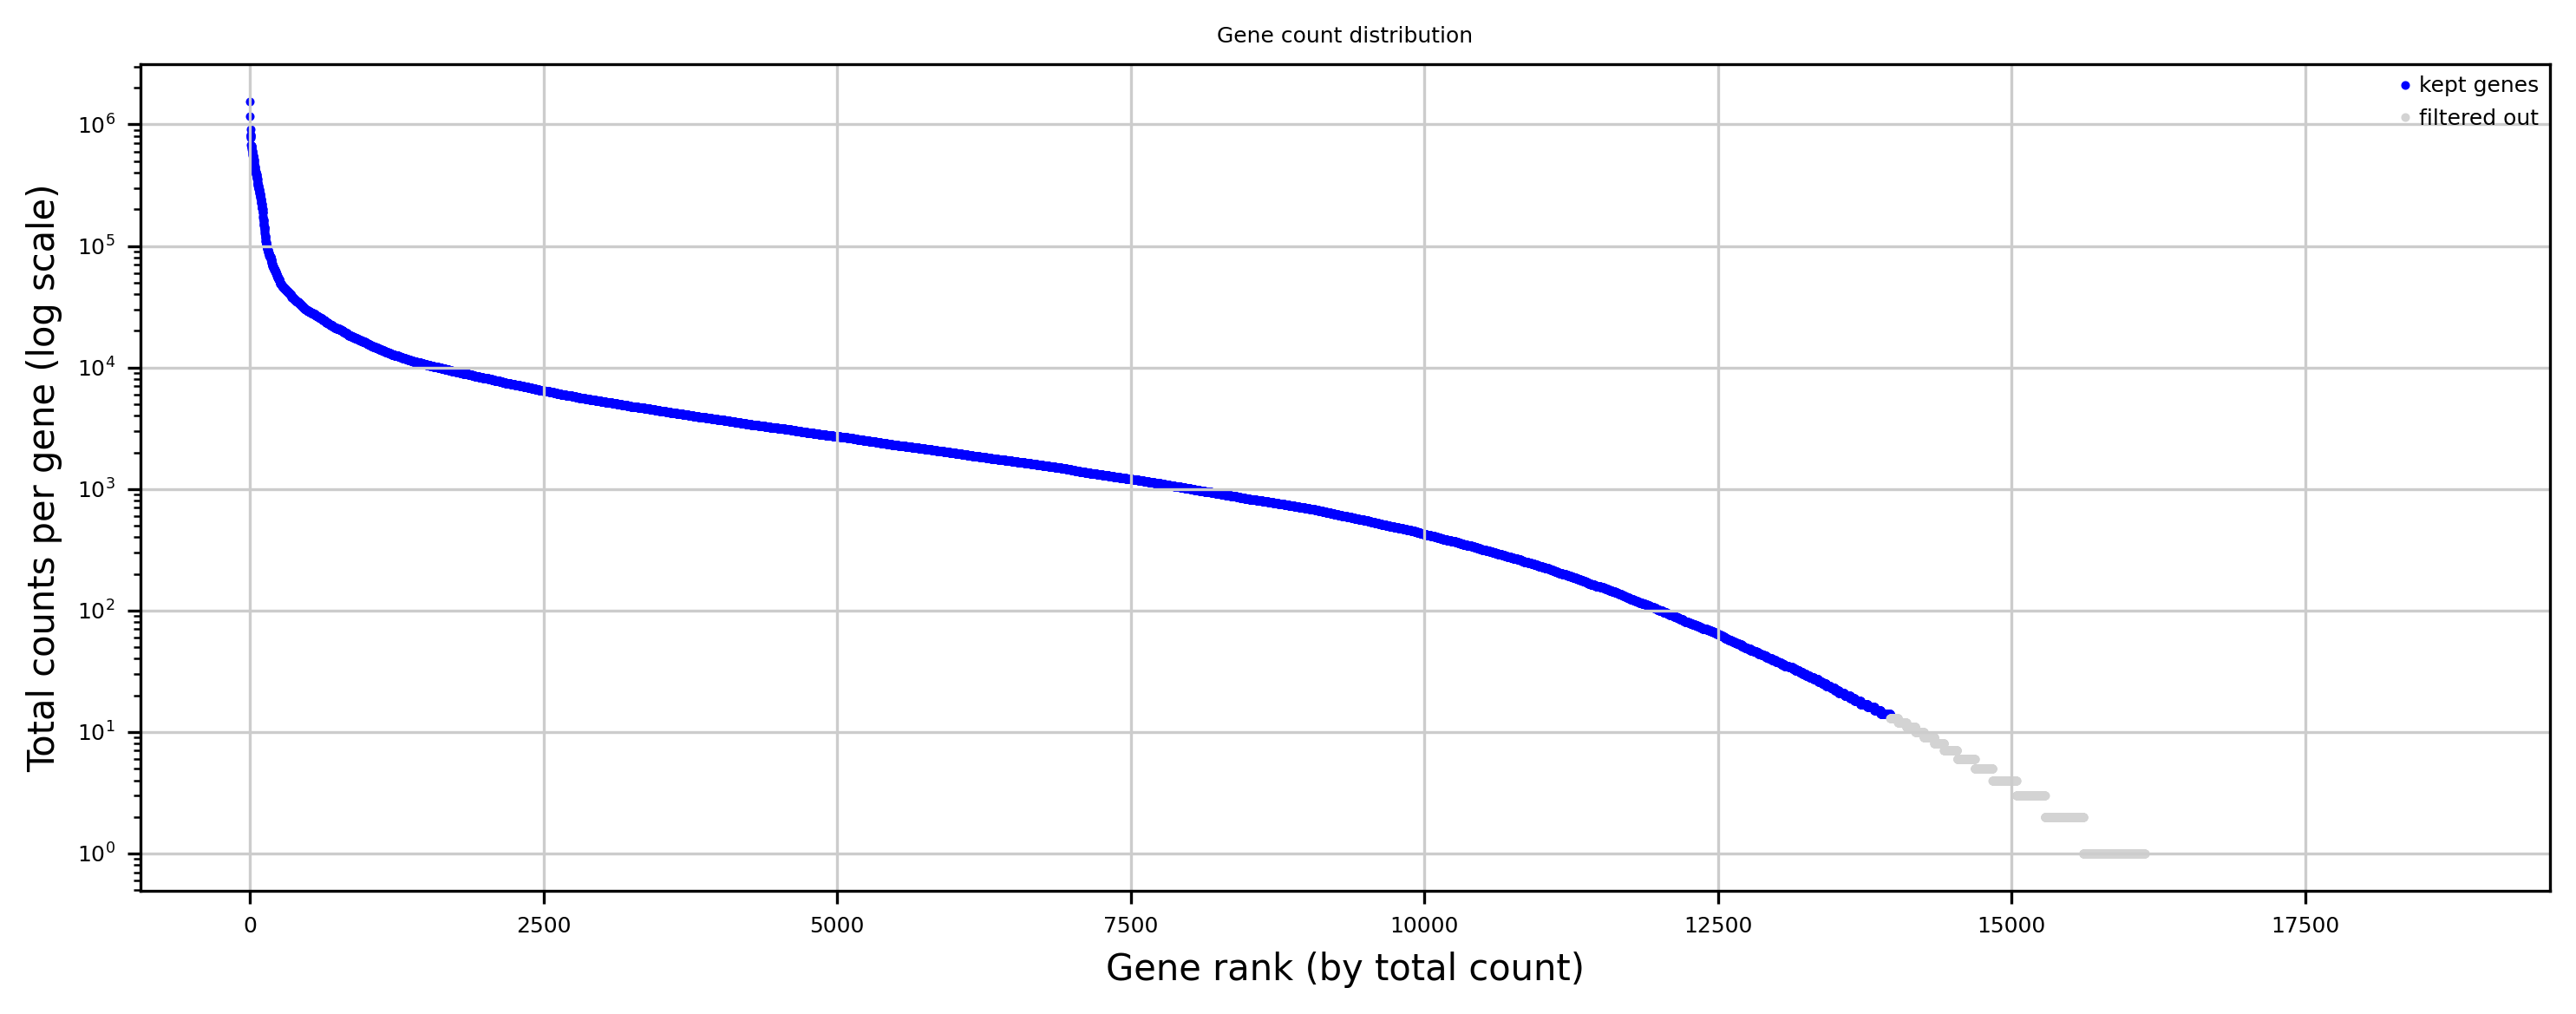

In [8]:
dx.pl.plot_filtered_genes(adata, keep_mask=keep_mask, layer="counts")

In [9]:
adata = adata[:, keep_mask].copy()

## 2. Pseudobulking

Pseudobulking is a common preprocessing step in single-cell differential expression analysis. Instead of analyzing individual cells—which introduces challenges due to sparsity, high variability, and non-independence—we aggregate expression values across biologically meaningful groups, such as cell types and samples.

In this step, we:

1. **Group cells** by a combination of categories (e.g., `cell_type`, `sample`, `condition`).
2. **Sum or average** the raw counts for each gene across all cells in each group.
3. **Construct a pseudobulk matrix**, where each column corresponds to one group and each row to a gene.

This transforms sparse single-cell data into a bulk-like format that can be analyzed using well-established bulk RNA-seq differential expression tools such as **edgeR**, **DESeq2**, or **limma-voom**

In [10]:
adata_pb = dx.pp.pseudobulk(
    adata,
    sample_key=sample_key,  # Sample key for pseudobulk aggregation (the biological replicate)
    group_key=group_key,  # Group key for pseudobulk aggregation
    layer="counts",  # Layer to use for pseudobulk aggregation, e.g. "counts" or None for adata.X
    mode="sum",
)

print(adata_pb)

AnnData object with n_obs × n_vars = 28 × 13967
    obs: 'psbulk_replicate', 'cell_type', 'organoid', 'GLI3_KO', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    layers: 'psbulk_props'


In [79]:
sc.get.obs_df(adata_pb, [group_key, condition_key, "OTP"])

cell_type condition     OTP
GLI3_KO_D1_45d_ge_in          ge_in      True    13.0
GLI3_KO_D2_45d_ge_in          ge_in      True    12.0
GLI3_KO_I1_45d_ge_in          ge_in      True    30.0
GLI3_KO_I2_45d_ge_in          ge_in      True     1.0
GLI3_WT1_45d_ge_in            ge_in     False     0.0
GLI3_WT2_45d_ge_in            ge_in     False     0.0
GLI3_WT3_45d-1_ge_in          ge_in     False     0.0
GLI3_KO_D1_45d_ge_npc        ge_npc      True    13.0
GLI3_KO_D2_45d_ge_npc        ge_npc      True    22.0
GLI3_KO_I1_45d_ge_npc        ge_npc      True     7.0
GLI3_KO_I2_45d_ge_npc        ge_npc      True     4.0
GLI3_WT1_45d_ge_npc          ge_npc     False     3.0
GLI3_WT2_45d_ge_npc          ge_npc     False     0.0
GLI3_WT3_45d-1_ge_npc        ge_npc     False     0.0
GLI3_KO_D1_45d_mesen_ex    mesen_ex      True  1088.0
GLI3_KO_D2_45d_mesen_ex    mesen_ex      True   638.0
GLI3_KO_I1_45d_mesen_ex    mesen_ex      True  1349.0
GLI3_KO_I2_45d_mesen_ex    mesen_ex      True   170.0
GLI3_WT1_45d_mesen_ex      mesen_ex     False   109.0
GLI3_WT2_45d_mesen_ex      mesen_ex     False    22.0
GLI3_WT3_45d-1_mesen_ex    mesen_ex     False    20.0
GLI3_KO_D1_45d_mesen_npc  mesen_npc      True    30.0
GLI3_KO_D2_45d_mesen_npc  mesen_npc      True    13.0
GLI3_KO_I1_45d_mesen_npc  mesen_npc      True    31.0
GLI3_KO_I2_45d_mesen_npc  mesen_npc      True     8.0
GLI3_WT1_45d_mesen_npc    mesen_npc     False     1.0
GLI3_WT2_45d_mesen_npc    mesen_npc     False     0.0
GLI3_WT3_45d-1_mesen_npc  mesen_npc     False     0.0

## 3. Differential Expression Analysis

In [11]:
# Compute size factors
dx.pp.size_factors(adata_pb, method="ratio")

# Estimate dispersion parameters
dx.pp.dispersion(adata_pb, size_factor_key="size_factor", method="deseq2")

  0%|          | 0/7 [00:00<?, ?it/s]INFO:2025-07-02 14:40:49,196:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-07-02 14:40:49 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-07-02 14:40:49 | [WARNING] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


In [30]:
# Run differential expression analysis
results = dx.tl.de(
    adata_pb,
    condition_key=condition_key,
    group_key=group_key,
    mode="all_vs_ref",
    reference="False",
    method="negbinom",
    size_factor_key="size_factor",
    dispersion_key="dispersion",
)

Inferred data type: counts
13693 features passed log2fc threshold of 0.0


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Inferred data type: counts
13893 features passed log2fc threshold of 0.0


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Inferred data type: counts
13918 features passed log2fc threshold of 0.0


100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


Inferred data type: counts
13945 features passed log2fc threshold of 0.0


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


In [33]:
# TODO: For some reason we observe duplicate entries from the DE results.
# We need to make sure that there is only one entry for each feature - comparison combination
results = results.drop_duplicates(subset=["group", "feature"], keep="first")

In [34]:
results.to_csv("test.csv")

## 4. Visualization

Once differential expression analysis has been performed, it's important to visualize the results to interpret and communicate key findings. We begin by preparing the DE results, for example by labeling genes as upregulated, downregulated, or not significantly changed based on thresholds for log fold-change and adjusted p-value.

We then explore the results at multiple levels:

- **Volcano plots** to visualize the magnitude and significance of gene-level changes.
- **Matrix plots** and **Dot plots** to summarize the expression of differentially expressed genes across multiple conditions or groups.
- **Violin plots** to perform finer-grained comparisons of selected genes across specific conditions, cell types, or perturbations.

These visualizations help identify meaningful patterns in the data and support biological interpretation of the results.

#### Label DE genes

In [10]:
results = pd.read_csv("test.csv", index_col=0)

In [11]:
# First we will label DE genes
dx.pp.label_de_genes(results, coef_thresh=2, pval_thresh=0.05, auc_thresh=0)

In [12]:
results.head()

feature  test_condition  ref_condition  log2fc     auroc       coef  \
0   NXPH3            True          False   -10.0  0.333333 -14.072805   
1    THRB            True          False   -10.0  0.166667 -14.066088   
2   APOC3            True          False   -10.0  0.333333 -14.503799   
3    PAX3            True          False   -10.0  0.000000 -15.307692   
4    INHA            True          False   -10.0  0.166667 -14.187171   

           pval          padj  group  -log10(pval)  separation significant  
0  1.000000e-50  4.968548e-49  ge_in          50.0    0.166667        Down  
1  1.000000e-50  4.968548e-49  ge_in          50.0    0.333333        Down  
2  1.000000e-50  4.968548e-49  ge_in          50.0    0.166667        Down  
3  1.000000e-50  4.968548e-49  ge_in          50.0    0.500000        Down  
4  1.000000e-50  4.968548e-49  ge_in          50.0    0.333333        Down

#### Plot volcano plots

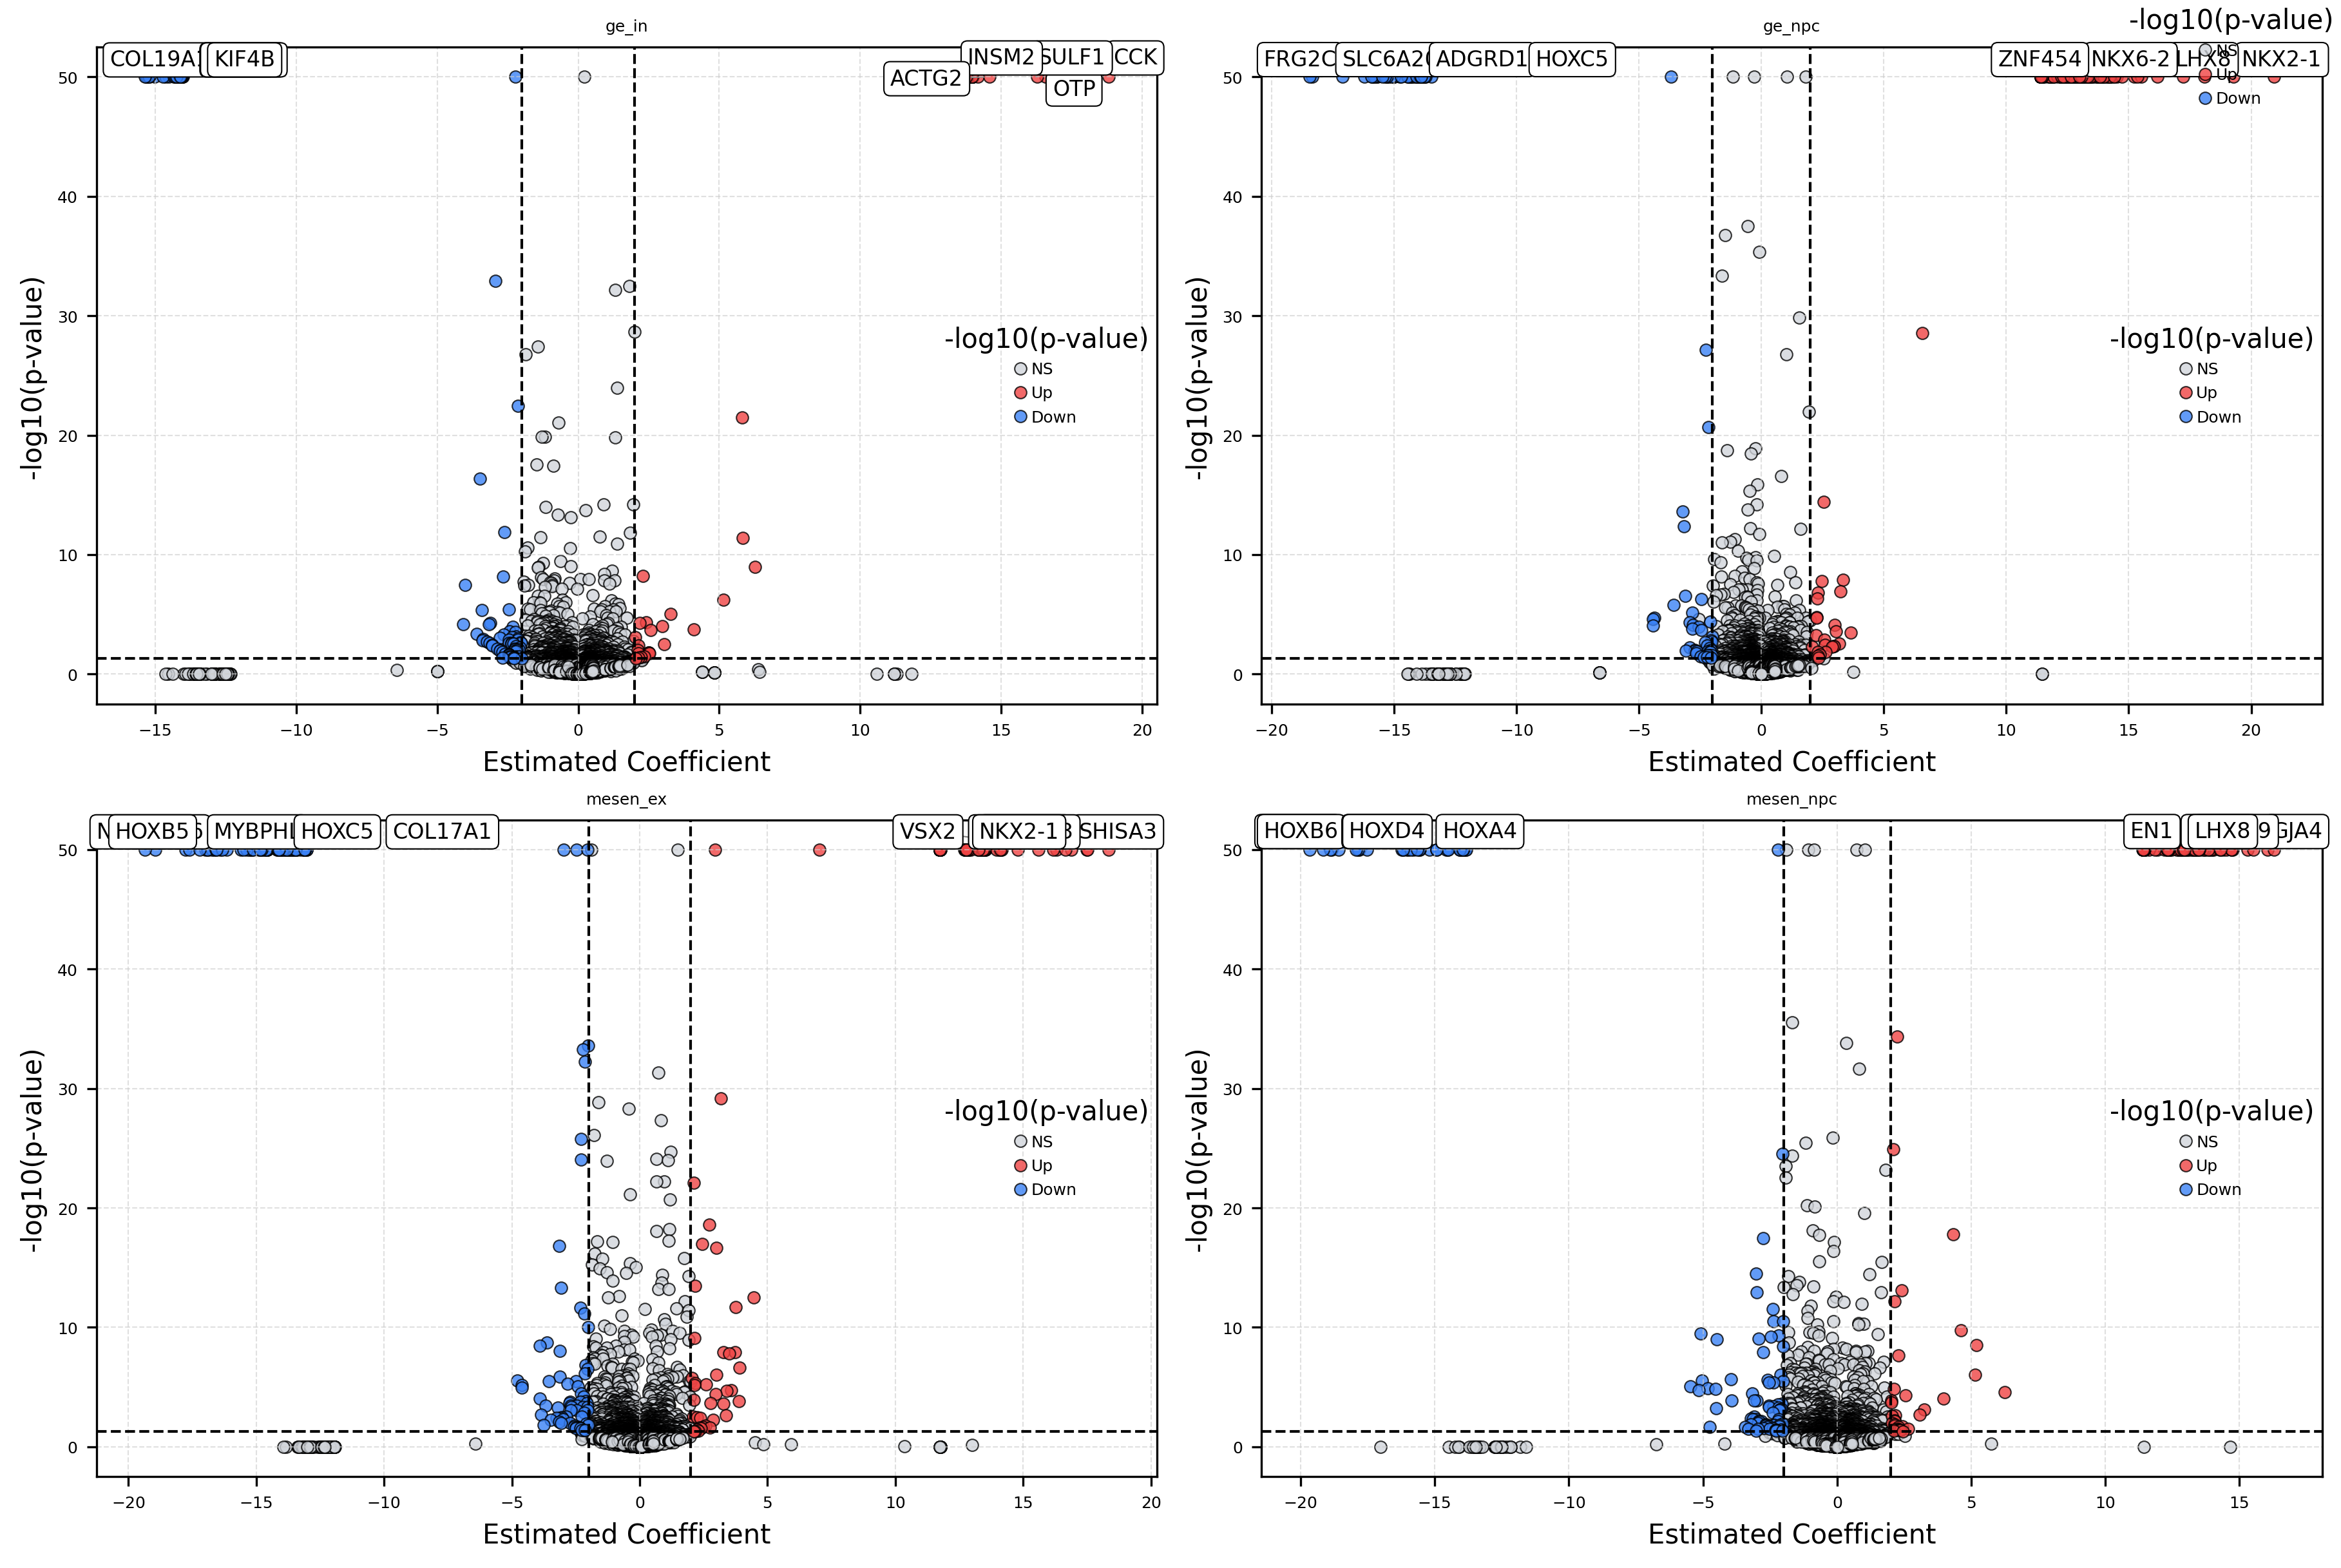

In [57]:
# Select groups to show
groups_to_plot = ["ge_in", "ge_npc", "mesen_ex", "mesen_npc"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()

for i, group in enumerate(groups_to_plot):
    ax = axs[i]
    de_df = results[results["group"] == group].copy()
    dx.pl.volcanoplot(
        de_df,
        thresh={"coef": 2, "-log10(pval)": -np.log10(0.05)},
        label_top=5,
        ax=ax,
        show=False,
    )
    ax.set_title(group)

# Remove empty axes if any
for j in range(len(groups_to_plot), len(axs)):
    fig.delaxes(axs[j])

# Add legend once (optional)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="-log10(p-value)", loc="upper right")

plt.show()

#### Plot matrix/dotplots

In [14]:
adata.layers["scaled"] = adata.X

sc.pp.scale(adata, layer="scaled")

/pstore/data/ihb-g-deco/USERS/adaml9/miniforge3/envs/delnx/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [15]:
top_up_per_group = (
    results[results["significant"] == "Up"]  # only upregulated genes
    .drop_duplicates(subset=["group", "feature"], keep="first")  # remove group-feature duplicates
    .sort_values(["group", "coef"], ascending=[True, False])  # sort by group and descending coef
)

In [16]:
top_up_per_group.head()

feature  test_condition  ref_condition  log2fc  auroc       coef  \
548     CCK            True          False    10.0  1.000  18.812918   
870     OTP            True          False    10.0  1.000  18.244787   
651   SULF1            True          False    10.0  1.000  16.561844   
704   INSM2            True          False    10.0  0.875  16.260147   
736   ACTG2            True          False    10.0  1.000  14.590841   

             pval          padj  group  -log10(pval)  separation significant  
548  1.000000e-50  4.968548e-49  ge_in          50.0       0.500          Up  
870  1.000000e-50  4.968548e-49  ge_in          50.0       0.500          Up  
651  1.000000e-50  4.968548e-49  ge_in          50.0       0.500          Up  
704  1.000000e-50  4.968548e-49  ge_in          50.0       0.375          Up  
736  1.000000e-50  4.968548e-49  ge_in          50.0       0.500          Up

In [17]:
top_up_per_group[top_up_per_group["feature"] == "OTP"]

feature  test_condition  ref_condition     log2fc  auroc       coef  \
870      OTP            True          False  10.000000    1.0  18.244787   
2264     OTP            True          False   4.607205    1.0   3.172541   
3662     OTP            True          False   6.219594    1.0   3.959701   

              pval          padj      group  -log10(pval)  separation  \
870   1.000000e-50  4.968548e-49      ge_in     50.000000         0.5   
2264  7.153867e-30  3.501101e-28   mesen_ex     29.145459         0.5   
3662  8.965919e-05  2.713708e-03  mesen_npc      4.047405         0.5   

     significant  
870           Up  
2264          Up  
3662          Up

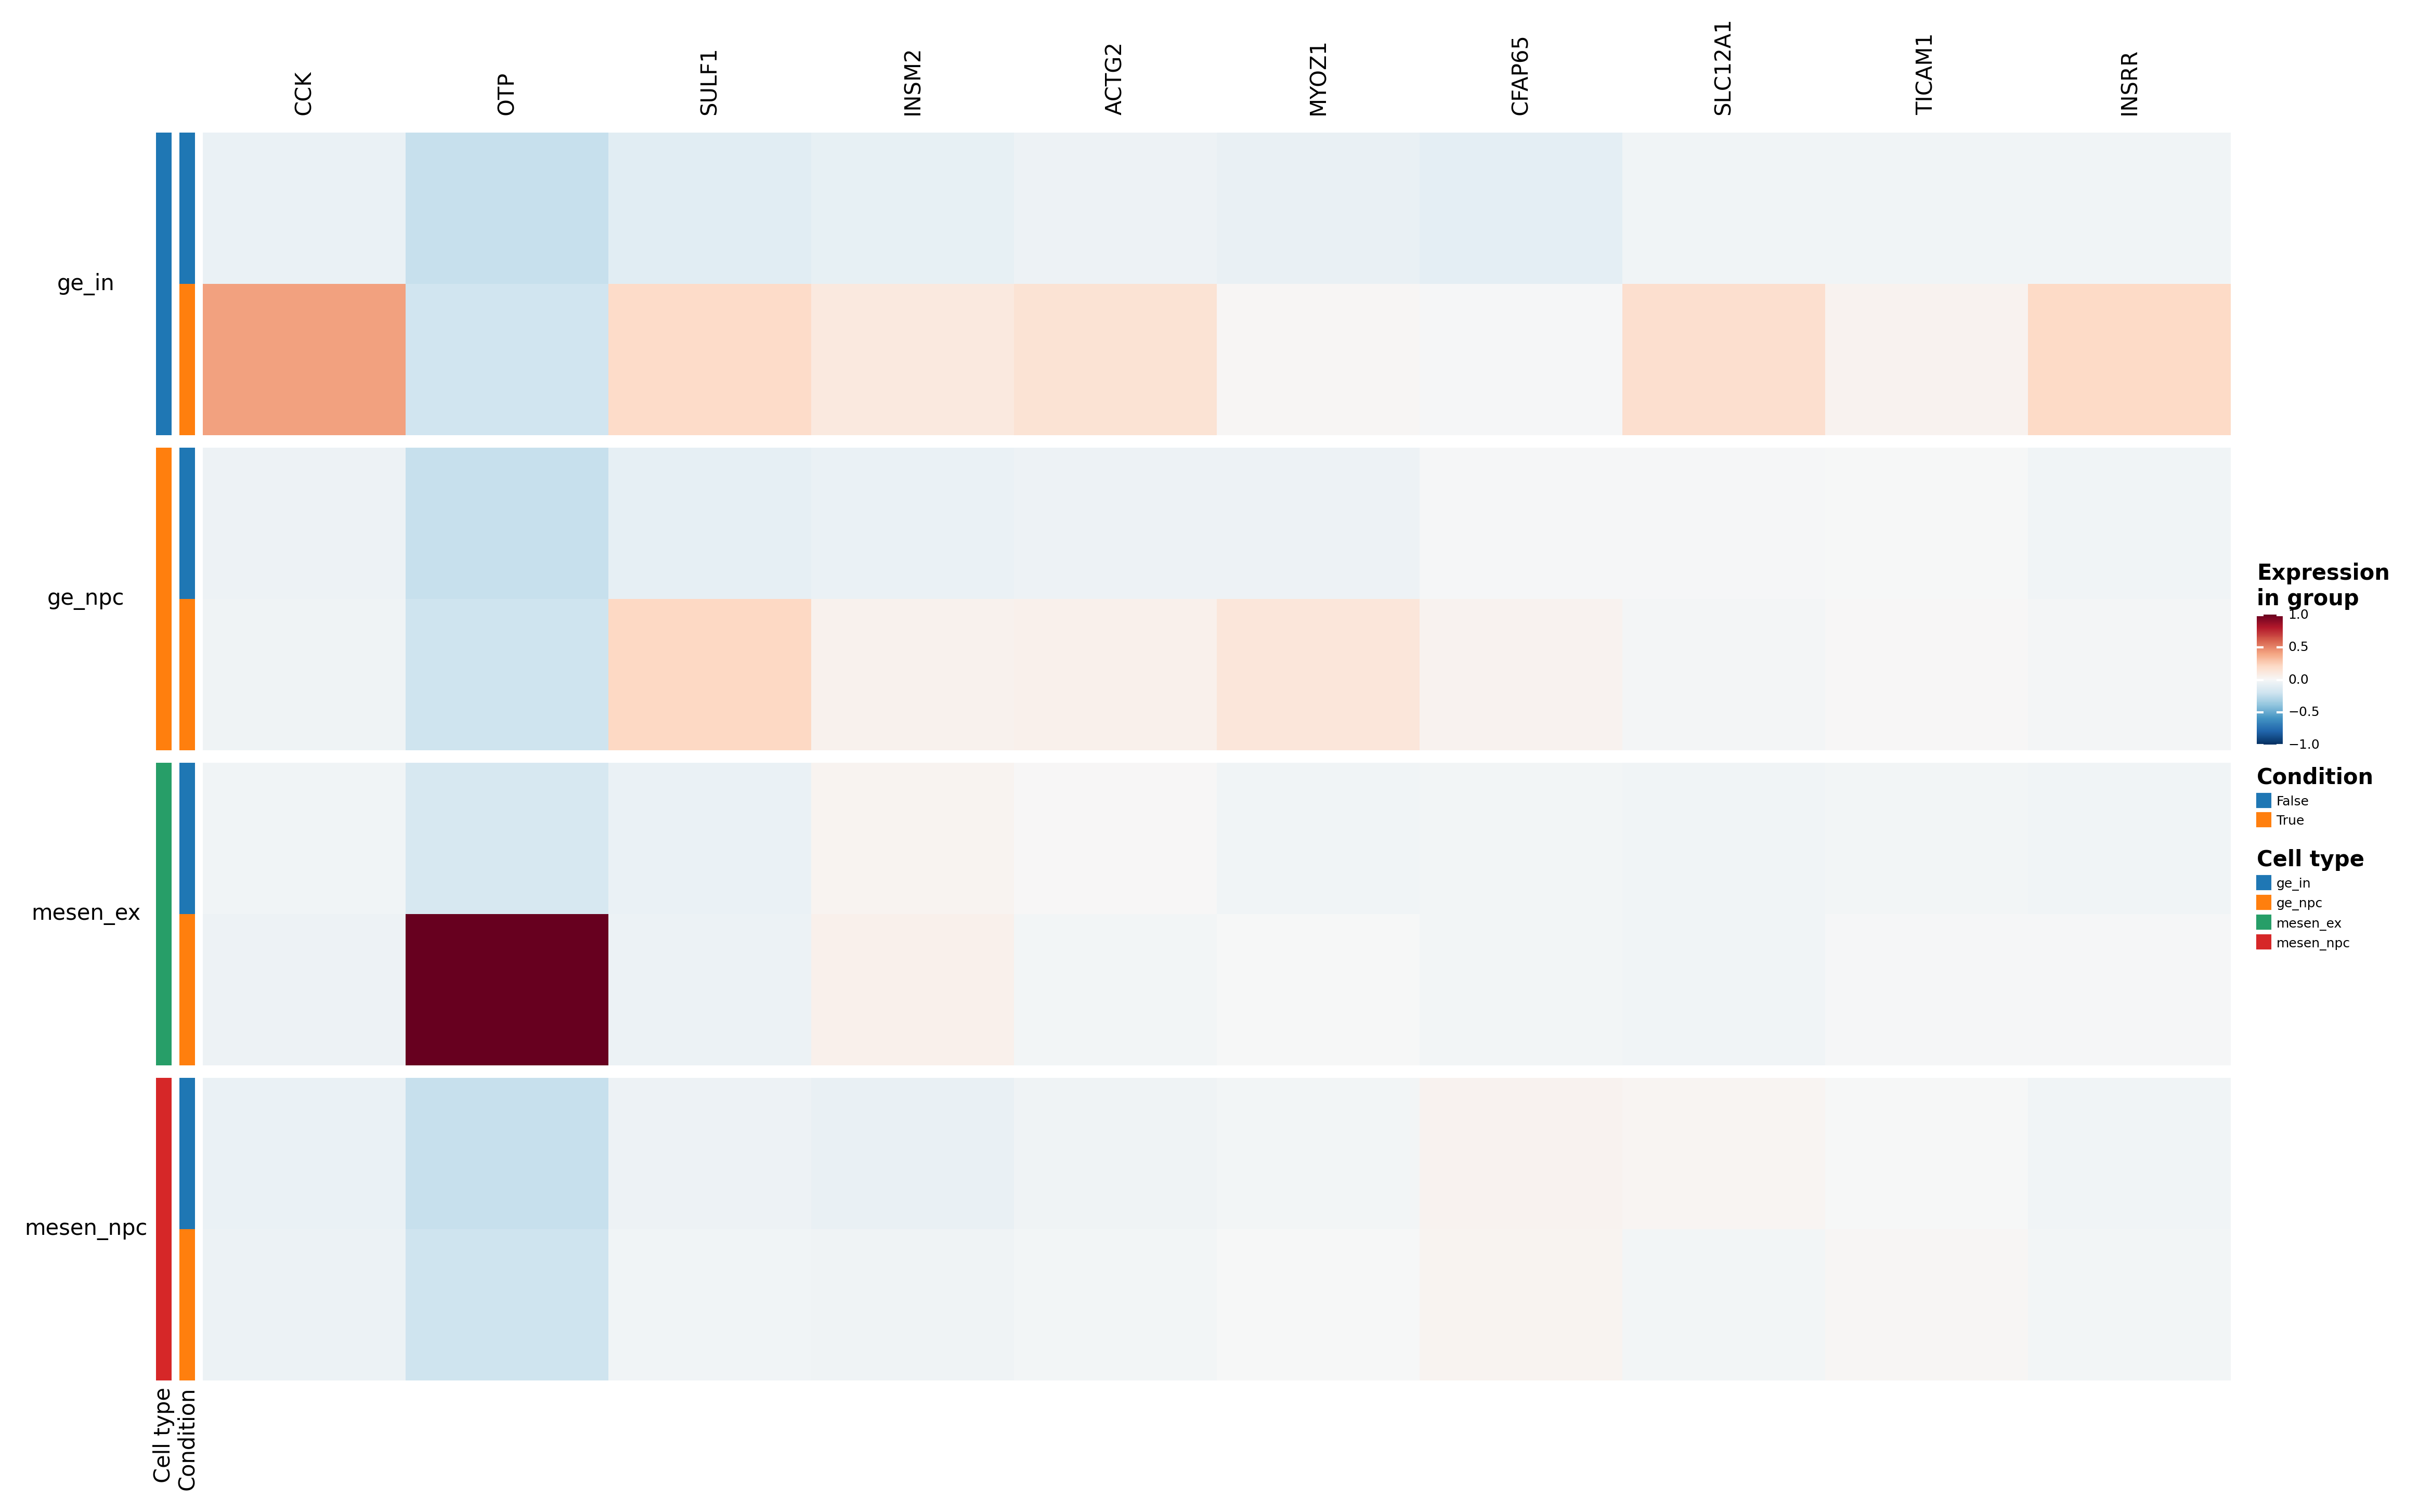

In [18]:
dx.pl.matrixplot(
    adata,
    markers=top_up_per_group["feature"].tolist()[:10],
    groupby=[group_key, condition_key],
    group_names=["Cell type", "Condition"],
    row_grouping=[group_key],
    column_grouping=True,
    layer="scaled",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    width=13,
    height=8,
    scale=1,
    show_legends=True,
    show_column_names=True,
    show_row_names=True,
)

2025-07-02 15:59:52 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 15:59:52 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 15:59:52 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 15:59:52 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 15:59:52 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

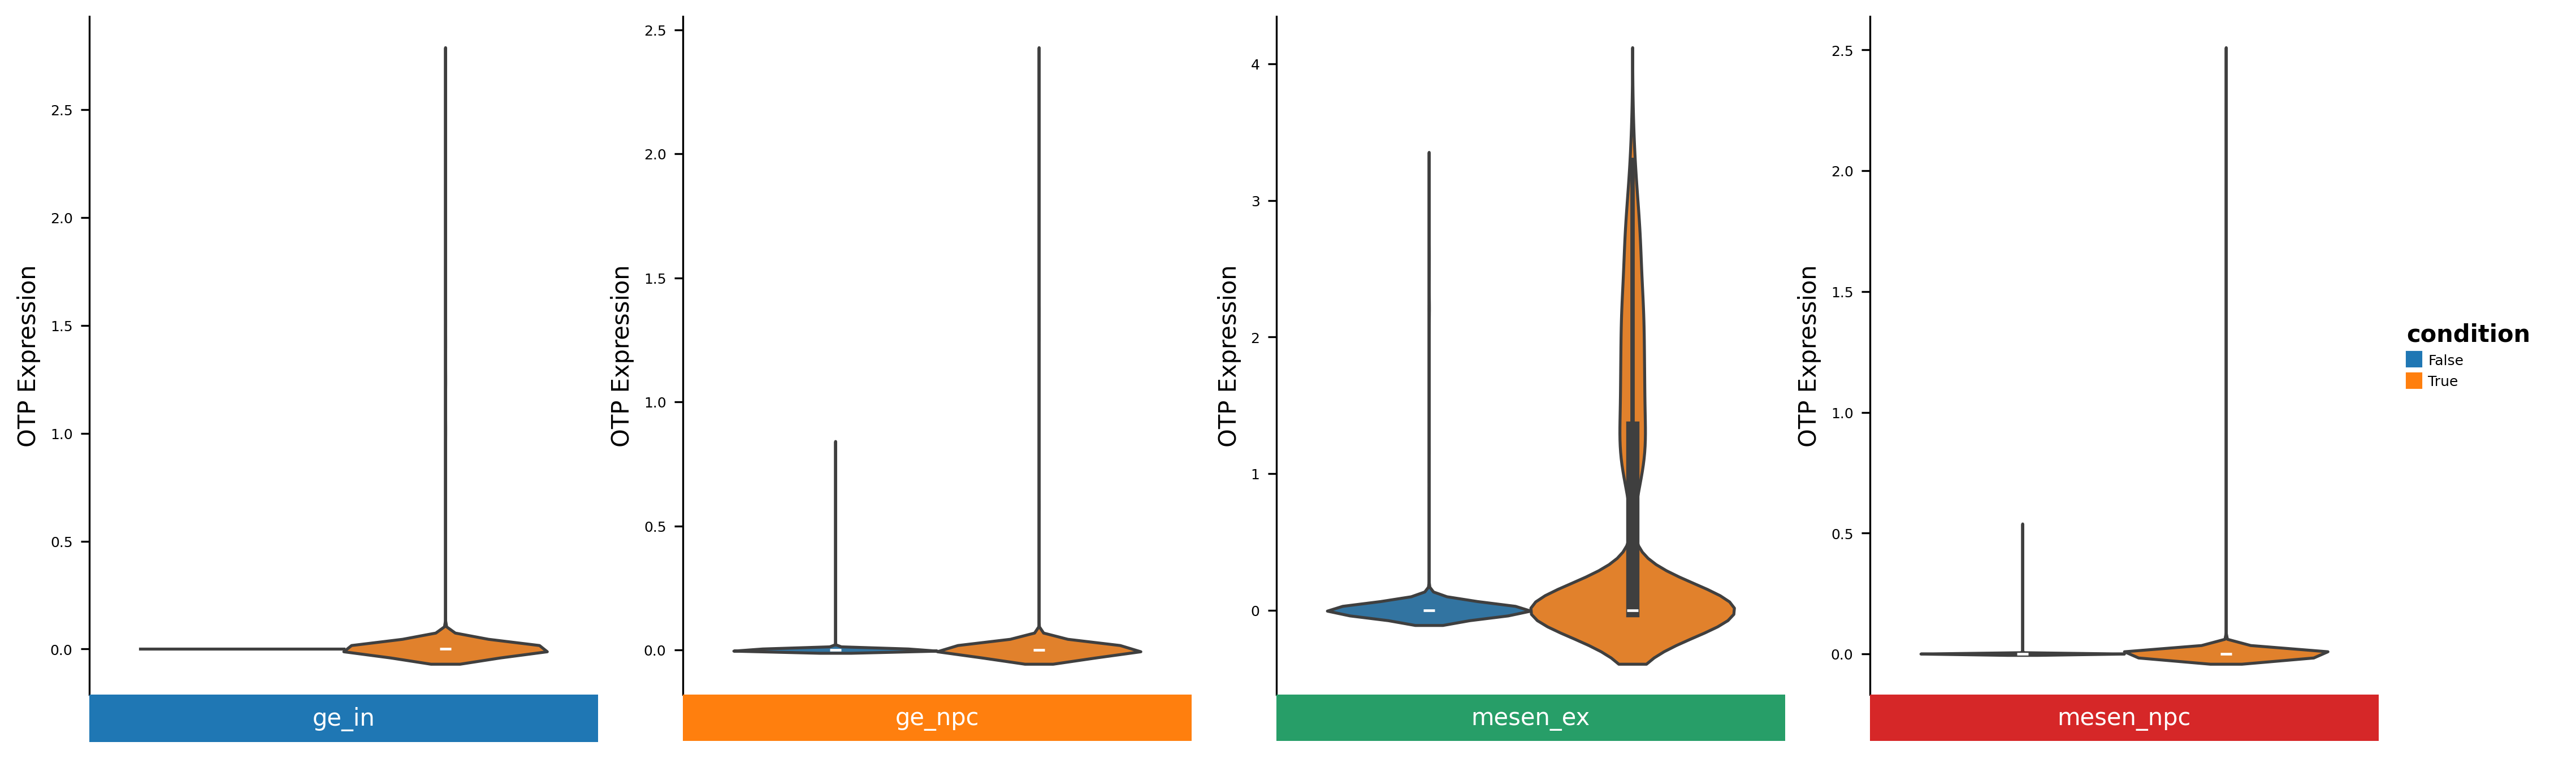

In [19]:
dx.pl.violinplot(adata, genes=["OTP"], groupby=group_key, splitby=condition_key, use_raw=False, flip=True)

#### Intersect differentially expressed genes

In [20]:
# Extract de genes
de_genes_dict = dx.pp.get_de_genes(results)

# Extract all "up" gene sets from the dictionary
up_gene_sets = [set(v["up"]) for v in de_genes_dict.values()]

# Compute the intersection of all sets
common_up_genes = list(set.intersection(*up_gene_sets))

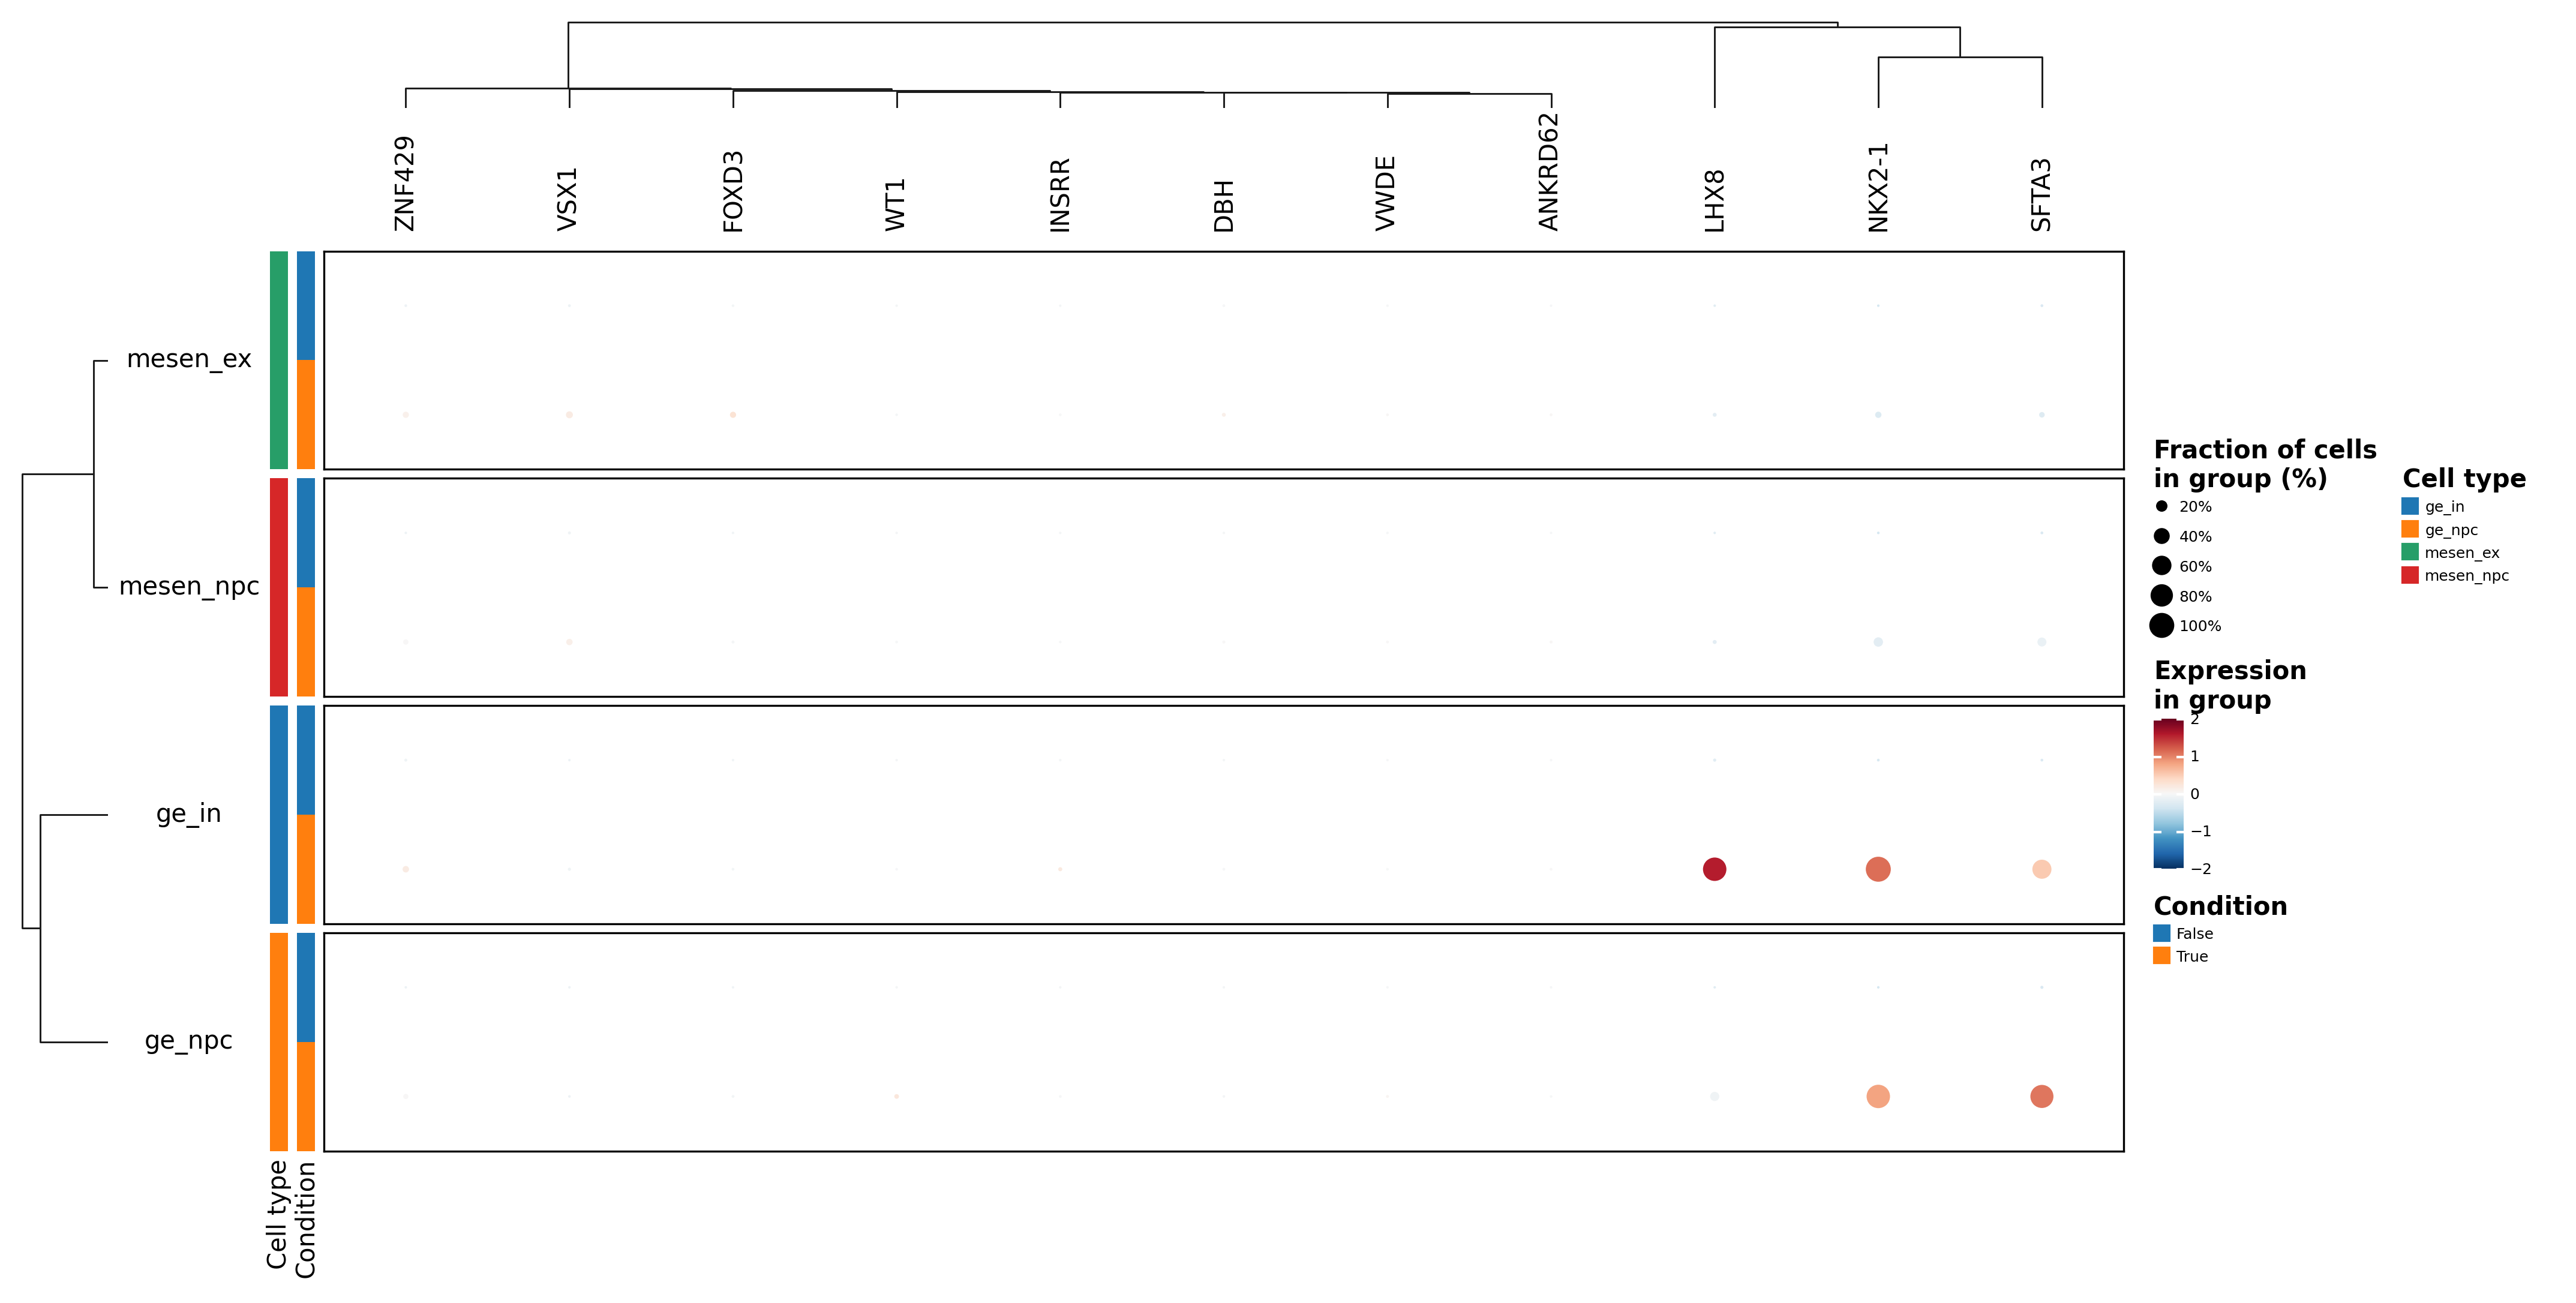

In [27]:
dx.pl.dotplot(
    adata,
    markers=common_up_genes,
    groupby=[group_key, condition_key],
    group_names=["Cell type", "Condition"],
    row_grouping=[group_key],
    column_grouping=True,
    dendrograms=["left", "top"],
    cmap="RdBu_r",
    layer="scaled",
    vmin=-2,
    vmax=2,
    center=0,
    width=10,
    height=5,
    scale=1,
    show_legends=True,
    show_column_names=True,
    show_row_names=True,
)

2025-07-02 16:00:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:00:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:00:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:00:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:00:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

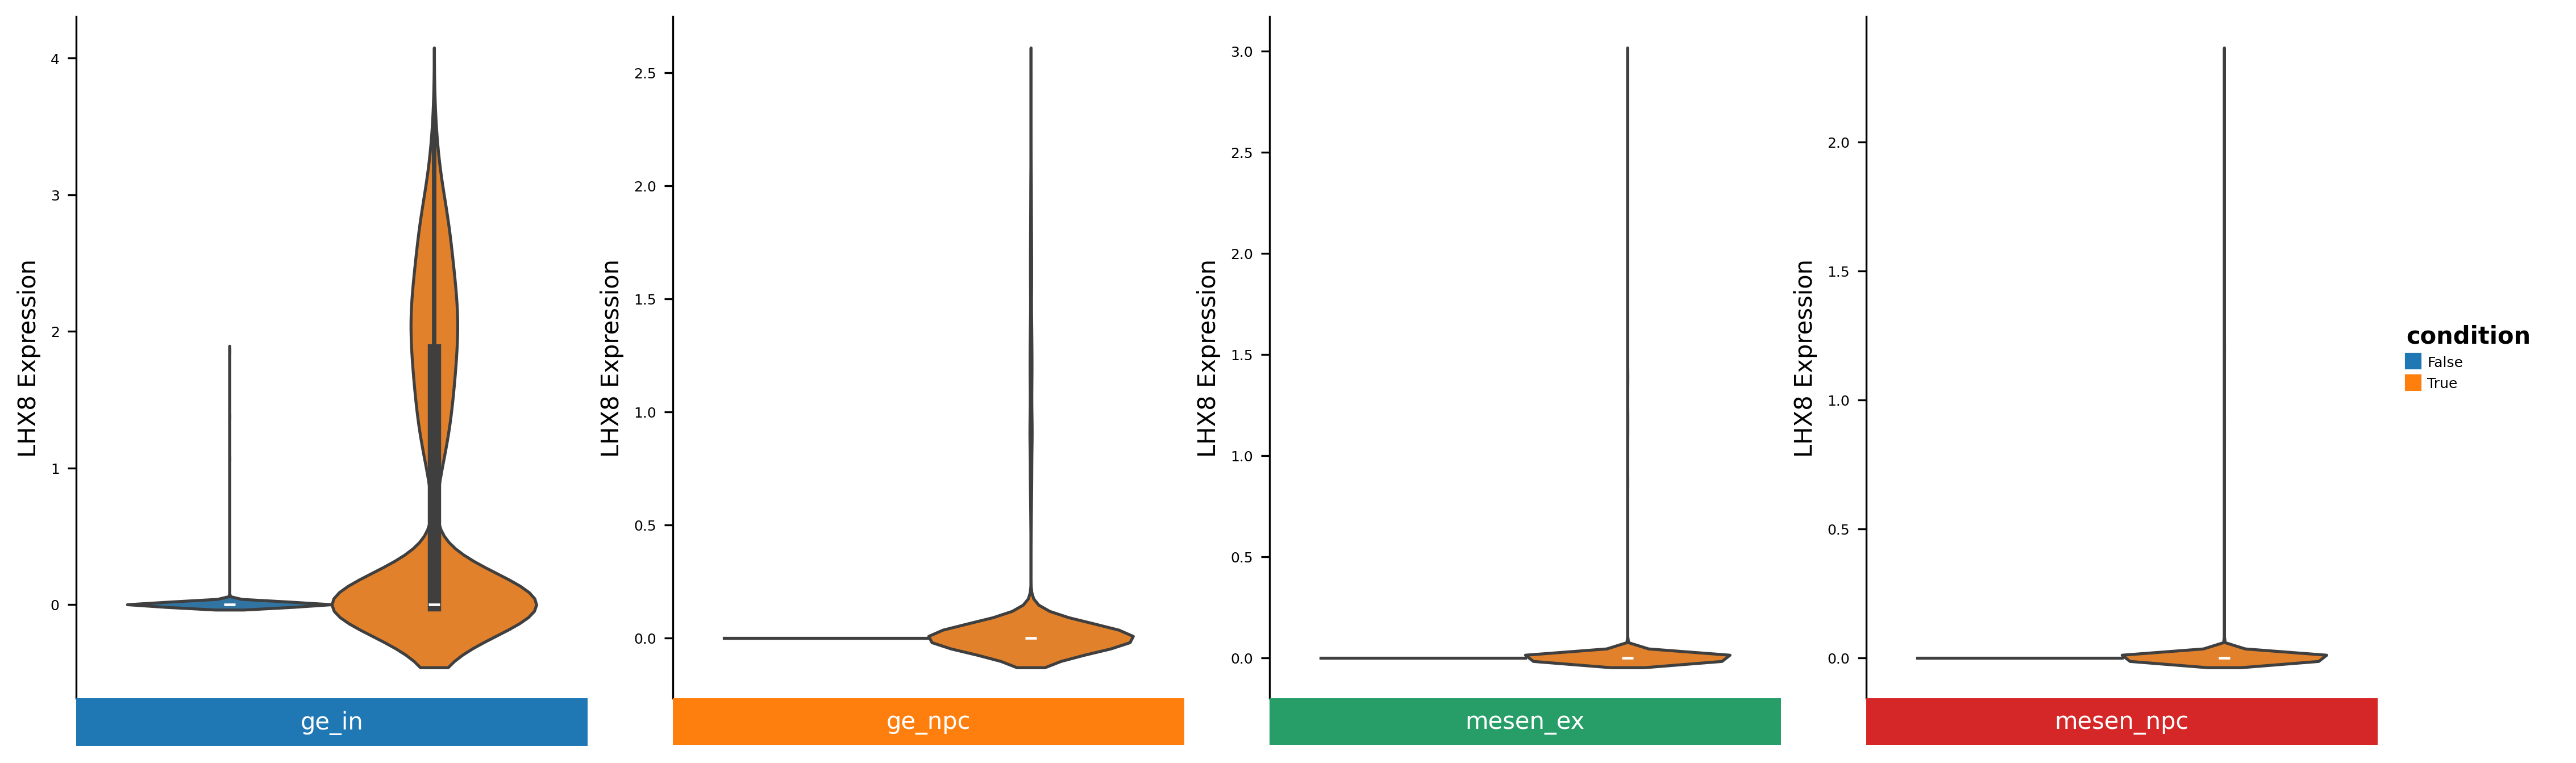

In [25]:
dx.pl.violinplot(adata, genes=["LHX8"], groupby=group_key, splitby=condition_key, use_raw=False, flip=True)

## 5. Gene Set Enrichment Analysis (GSEA)

In [28]:
# Run enrichment
enr_results = dx.tl.de_enrichment_analysis(results, cutoff=0.1)
enr_results = enr_results.rename(columns={"group": group_key})

In [29]:
enr_results.head()

Gene_set                                   Term Overlap   P-value  \
0  gs_ind_0                      AAAYRNCTG_UNKNOWN  14/374  0.000091   
1  gs_ind_0                     AACWWCAANK_UNKNOWN   5/146  0.023976   
2  gs_ind_0                  AATGTGA_MIR23A_MIR23B  10/422  0.020691   
3  gs_ind_0               ABBUD_LIF_SIGNALING_1_UP    3/43  0.012117   
4  gs_ind_0  ACEVEDO_LIVER_CANCER_WITH_H3K27ME3_UP  13/290  0.000026   

   Adjusted P-value  Odds Ratio  Combined Score  \
0          0.002447    3.652617       33.992581   
1          0.097339    3.479821       12.982197   
2          0.092865    2.288615        8.875396   
3          0.064388    7.722414       34.080081   
4          0.001051    4.417031       46.624776   

                                               Genes up_dw cell_type  
0  WT1;CER1;CA3;ESRRB;AXDND1;IGF1;HPSE2;PRELP;CAS...    UP     ge_in  
1                           ESPL1;DQX1;OTP;HAS2;EXO1    UP     ge_in  
2  ADGRG2;ALDH1A2;PRTG;TGFBR3;TMOD1;PLAU;C12orf54...    UP     ge_in  
3                               FBP1;TMEM176A;MAN1A1    UP     ge_in  
4  SULF1;KIAA1217;PRTG;MARCO;SLC35F2;C6orf141;STE...    UP     ge_in

2025-07-02 16:07:31 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:07:31 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:07:31 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:07:31 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 16:07:31 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

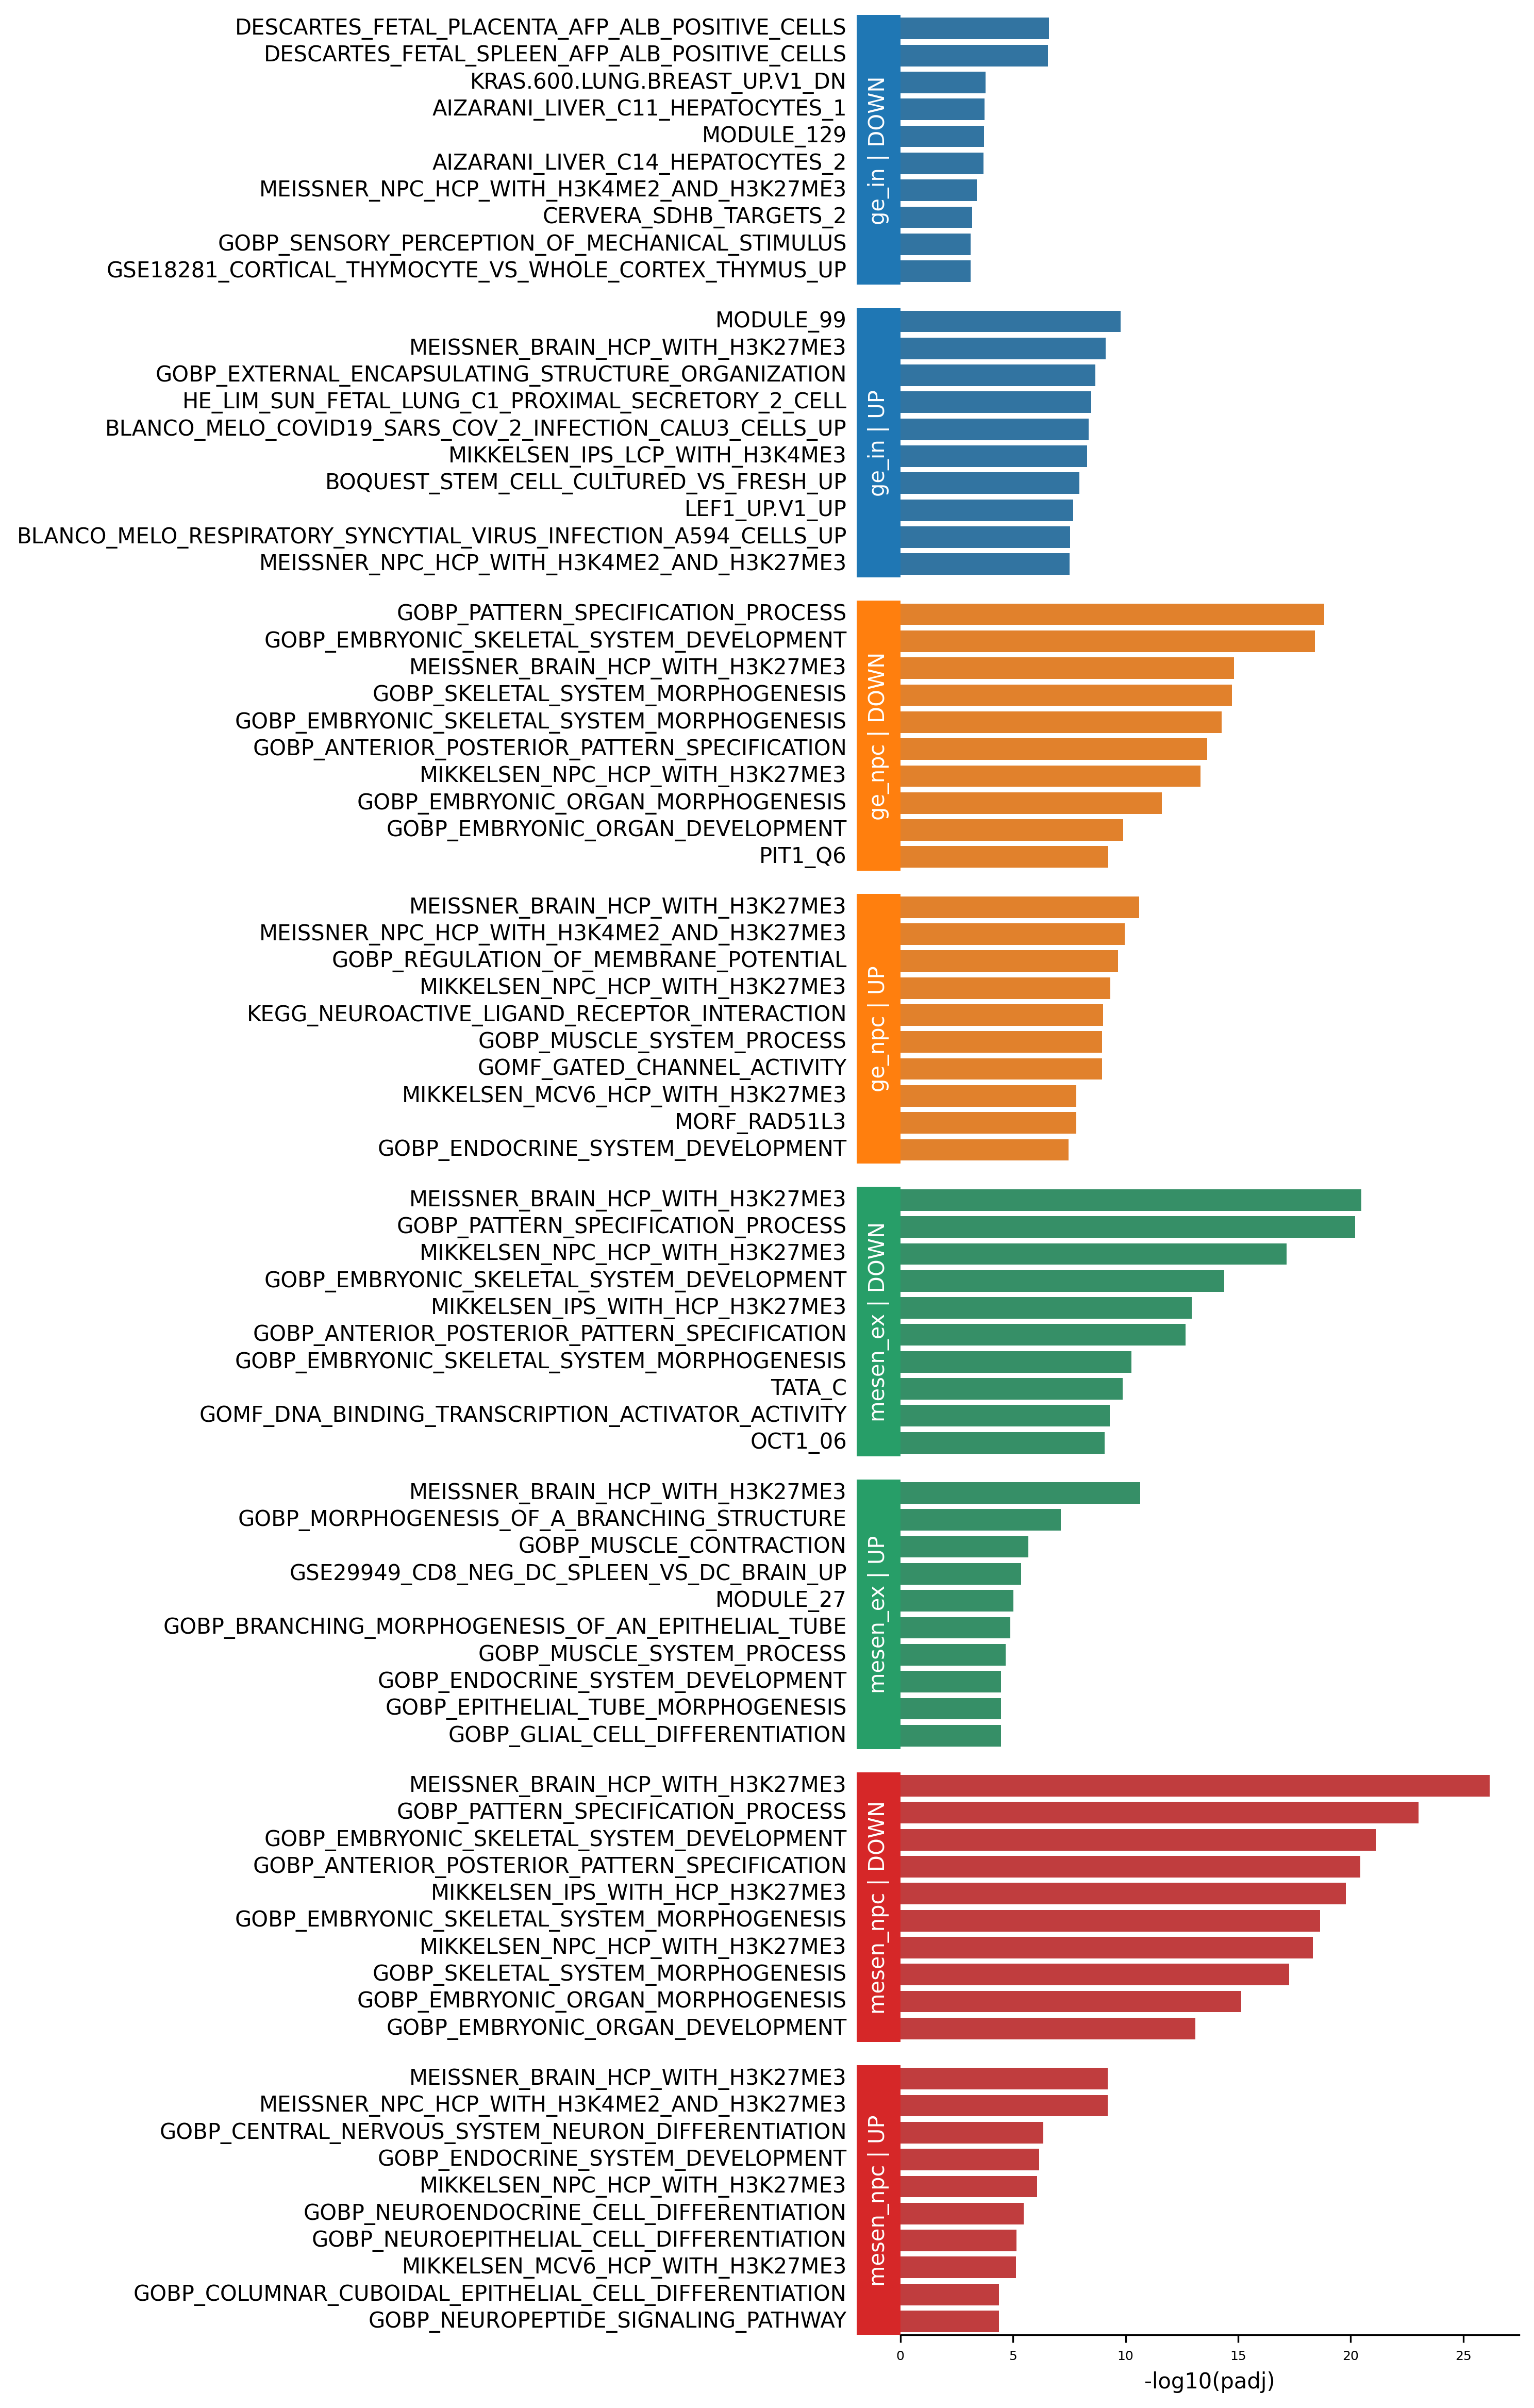

In [31]:
dx.pl.gsea_barplot(enr_results, group_key=["cell_type", "up_dw"], adata=adata, top_n=10, figsize=(4, 15))

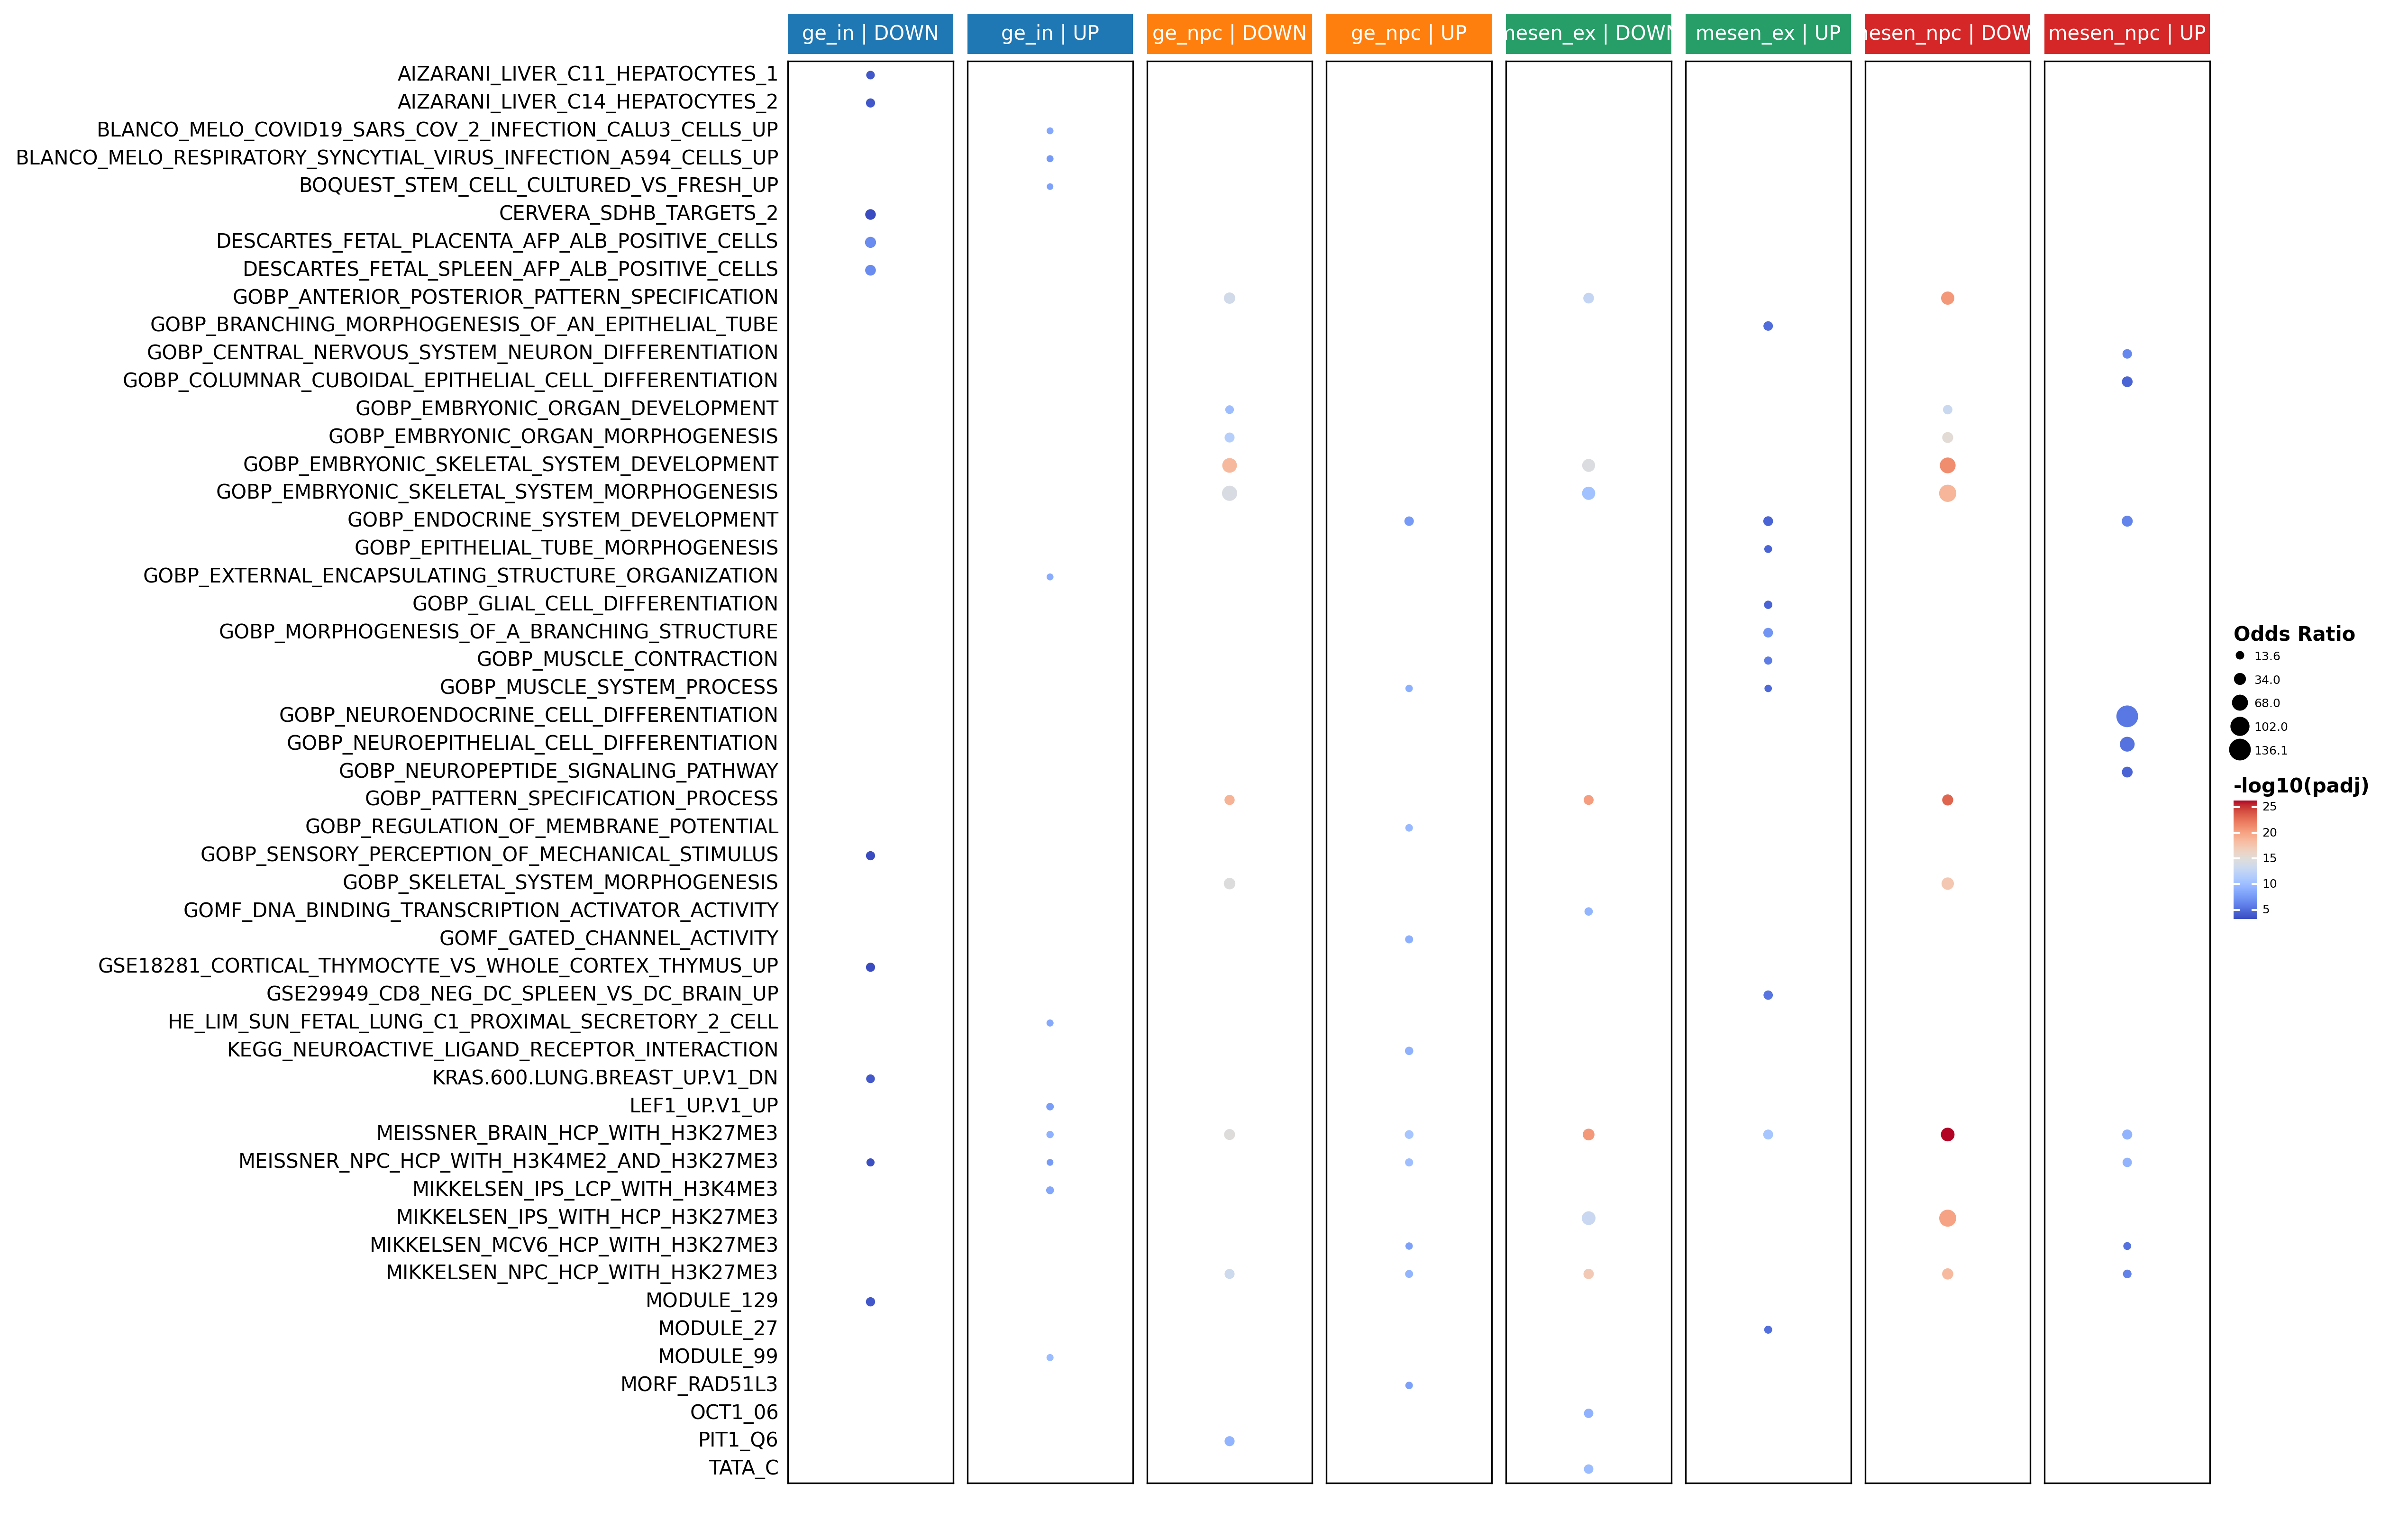

In [33]:
dx.pl.gsea_dotplot(enr_results, group_key=["cell_type", "up_dw"], adata=adata, top_n=10, figsize=(10, 10))